## Import du dataset et division en données normales / anormales 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model

In [2]:
# Check if TensorFlow detects a GPU
if tf.config.list_physical_devices('GPU'):
    print("A GPU is ready for use.")
else:
    print("No GPU is available.")

A GPU is ready for use.


In [3]:
import pandas as pd
import glob
import os

# Path to the folder containing .h5 files
dataset_path = "./Dataset"

# List of all .h5 files in the folder
h5_files = glob.glob(os.path.join(dataset_path, "*.h5"))

# Lists to store normal and abnormal DataFrames
normal_data_frames = []
anomaly_data_frames = []

# Load each .h5 file into a DataFrame and classify it
for file in h5_files:
    try:
        df = pd.read_hdf(file)
        
        # Identify abnormal files by the presence of keywords in the file name
        if "shift_on" in file:
            anomaly_data_frames.append(df)
            print(f"{file} classified as an anomaly.")
        else:
            normal_data_frames.append(df)
            print(f"{file} classified as normal.")
            
    except Exception as e:
        print(f"Error while loading {file}: {e}")


./Dataset\TimeSeries_Scenario_00001_ScenarioInstanceRandint_id_0001.h5 classified as normal.
./Dataset\TimeSeries_Scenario_00001_ScenarioInstanceRandint_id_0001_shift_on___flight_director_pitch__flight_director_roll.h5 classified as an anomaly.
./Dataset\TimeSeries_Scenario_00002_ScenarioInstanceRandint_id_0002.h5 classified as normal.
./Dataset\TimeSeries_Scenario_00003_ScenarioInstanceRandint_id_0003.h5 classified as normal.
./Dataset\TimeSeries_Scenario_00004_ScenarioInstanceRandint_id_0004.h5 classified as normal.
./Dataset\TimeSeries_Scenario_00005_ScenarioInstanceRandint_id_0005.h5 classified as normal.
./Dataset\TimeSeries_Scenario_00006_ScenarioInstanceRandint_id_0006.h5 classified as normal.
./Dataset\TimeSeries_Scenario_00006_ScenarioInstanceRandint_id_0006_shift_on___flight_director_pitch__flight_director_roll.h5 classified as an anomaly.
./Dataset\TimeSeries_Scenario_00007_ScenarioInstanceRandint_id_0007.h5 classified as normal.
./Dataset\TimeSeries_Scenario_00008_ScenarioI

In [4]:
# Calculate the percentage of normal and abnormal data
total_files = len(h5_files)
normal_percentage = (len(normal_data_frames) / total_files) * 100 if total_files > 0 else 0
anomaly_percentage = (len(anomaly_data_frames) / total_files) * 100 if total_files > 0 else 0

# Display the percentages
print(f"Percentage of normal data: {normal_percentage:.2f}%")
print(f"Percentage of abnormal data: {anomaly_percentage:.2f}%")

# Number of normal and abnormal time series
print(len(normal_data_frames))
print(len(anomaly_data_frames))

Percentage of normal data: 96.35%
Percentage of abnormal data: 3.65%
949
36


In [5]:
def check_dataframe_sizes(dataframes):
    """
    Checks the sizes of DataFrames in a list.

    Parameters:
    - dataframes (list): List containing pandas DataFrames.

    Returns:
    - dict: A dictionary where keys are sizes (shapes) and values are 
            the indices of the corresponding DataFrames.
    """
    size_dict = {}
    for i, df in enumerate(dataframes):
        size = df.shape
        if size not in size_dict:
            size_dict[size] = []
        size_dict[size].append(i)
    return size_dict

In [6]:
# Display the sizes of DataFrames
print("Sizes of DataFrames in normal_data_frames:")
normal_data_sizes = check_dataframe_sizes(normal_data_frames)
for size, indices in normal_data_sizes.items():
    print(f"Size {size}: {len(indices)} simulations")

Sizes of DataFrames in normal_data_frames:
Size (3582, 135): 559 simulations
Size (3583, 135): 341 simulations
Size (3584, 135): 35 simulations
Size (3581, 135): 13 simulations
Size (3585, 135): 1 simulations


In [7]:
print("Sizes of DataFrames in anomaly_data_frames:")
anomaly_data_sizes = check_dataframe_sizes(anomaly_data_frames)
for size, indices in anomaly_data_sizes.items():
    print(f"Size {size}: {len(indices)} simulations")

Sizes of DataFrames in anomaly_data_frames:
Size (3582, 137): 21 simulations
Size (3583, 137): 15 simulations


In [8]:
# Standardize all DataFrame sizes to (3581, 135)
for i in range(len(normal_data_frames)):
    if normal_data_frames[i].shape[0] > 3581:
        # Remove excess rows from the end
        normal_data_frames[i] = normal_data_frames[i].iloc[:3581, :]

for i in range(len(anomaly_data_frames)):
    if anomaly_data_frames[i].shape[0] > 3581:
        # Remove excess rows from the end
        anomaly_data_frames[i] = anomaly_data_frames[i].iloc[:3581, :]


In [9]:
# Display sizes after adjustment
print("Sizes of DataFrames in normal_data_frames after adjustment:")
normal_data_sizes = check_dataframe_sizes(normal_data_frames)
for size, indices in normal_data_sizes.items():
    print(f"Size {size}: {len(indices)} simulations")

print("Sizes of DataFrames in anomaly_data_frames after adjustment:")
anomaly_data_sizes = check_dataframe_sizes(anomaly_data_frames)
for size, indices in anomaly_data_sizes.items():
    print(f"Size {size}: {len(indices)} simulations")

Sizes of DataFrames in normal_data_frames after adjustment:
Size (3581, 135): 949 simulations
Sizes of DataFrames in anomaly_data_frames after adjustment:
Size (3581, 137): 36 simulations


### 1. Prise en main des données et préparation à l'entrainement. 

### Identifier les colonnes anomalies 

In [10]:
# Compare the columns of DataFrames
def identify_new_columns(normal_data, anomaly_data):
    # Identify columns that are in anomaly_data but not in normal_data
    normal_columns = set(normal_data.columns)
    anomaly_columns = set(anomaly_data.columns)
    
    new_columns = anomaly_columns - normal_columns  # Columns present in anomaly_data but not in normal_data
    
    print(f"Number of new columns in 'anomaly_data': {len(new_columns)}")
    print(f"New columns in 'anomaly_data': {new_columns}")
    
    return new_columns

# Example call
new_columns = identify_new_columns(normal_data_frames[0], anomaly_data_frames[0])


Number of new columns in 'anomaly_data': 2
New columns in 'anomaly_data': {'sim/cockpit/autopilot/flight_director_roll_ground_truth', 'sim/cockpit/autopilot/flight_director_pitch_ground_truth'}


In [11]:
columns_anomalies = [
    'sim/cockpit/autopilot/flight_director_pitch',
    'sim/cockpit/autopilot/flight_director_roll'
]
columns_ground_truth = [
        'sim/cockpit/autopilot/flight_director_pitch_ground_truth',
    'sim/cockpit/autopilot/flight_director_roll_ground_truth'
]

### Affichage du paramètre présentant l'anomalie vs le normal

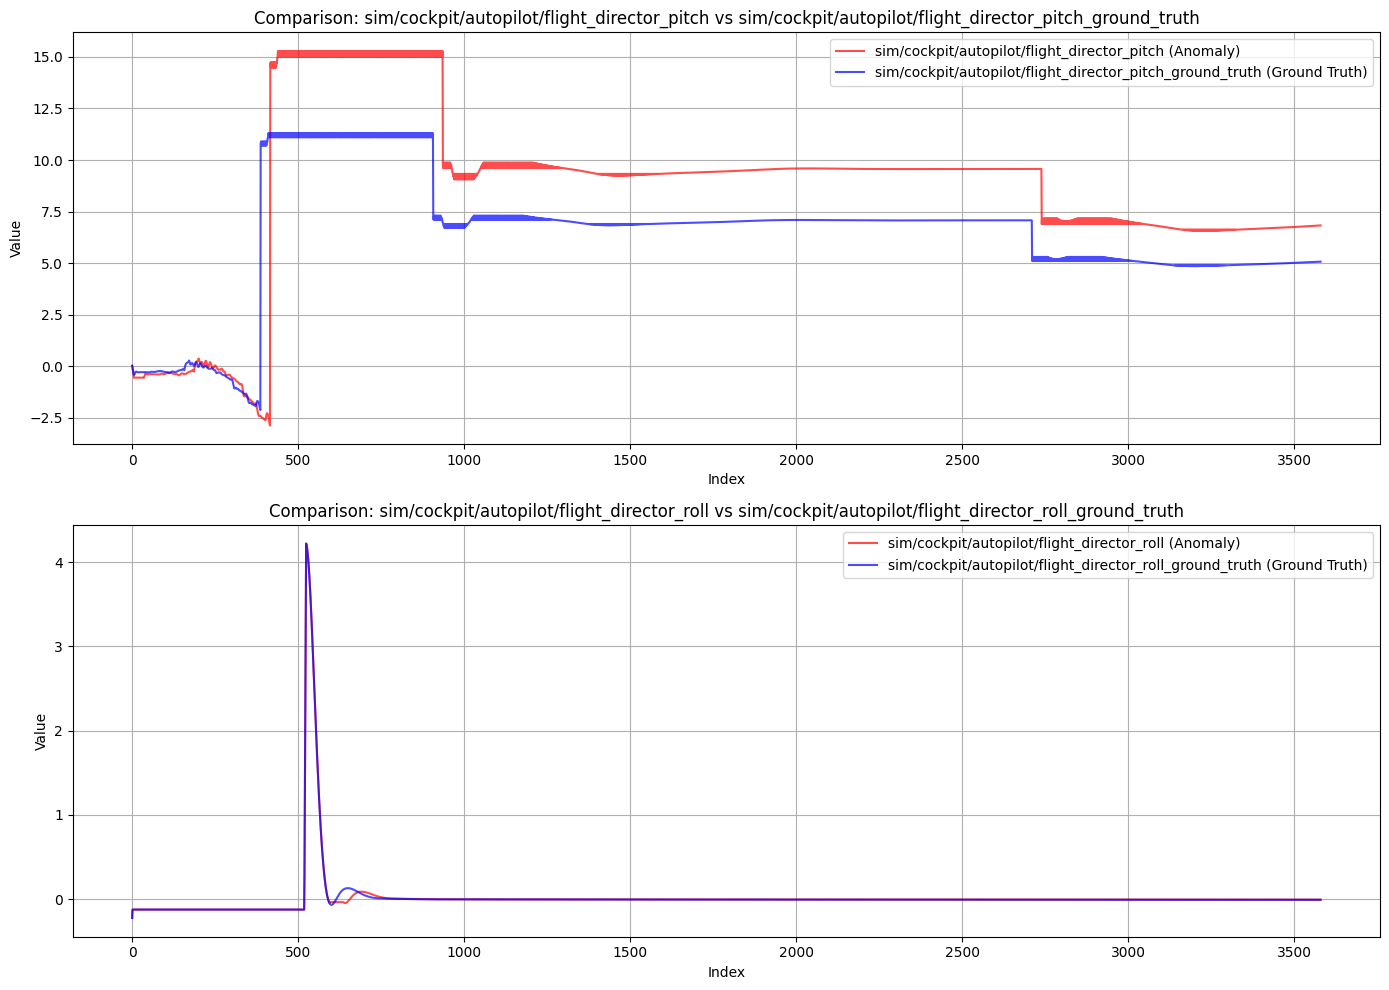

In [12]:
def display_variable_comparison(data, anomaly_variables, ground_truth_variables):
    """
    Displays curves to compare anomaly variables and ground truth variables.

    Parameters:
    - data: Data containing the variables to compare (DataFrame).
    - anomaly_variables: List of anomaly variable names.
    - ground_truth_variables: List of ground truth variable names.
    """
    plt.figure(figsize=(14, 5 * len(anomaly_variables)))

    # Iterate over each pair of variables
    for i, (anomaly_var, ground_truth_var) in enumerate(zip(anomaly_variables, ground_truth_variables)):
        plt.subplot(len(anomaly_variables), 1, i + 1)
        plt.plot(data[anomaly_var], label=f'{anomaly_var} (Anomaly)', color='red', alpha=0.7)
        plt.plot(data[ground_truth_var], label=f'{ground_truth_var} (Ground Truth)', color='blue', alpha=0.7)
        plt.title(f"Comparison: {anomaly_var} vs {ground_truth_var}")
        plt.legend()
        plt.xlabel("Index")
        plt.ylabel("Value")
        plt.grid()

    plt.tight_layout()
    plt.show()

# Example call to the function
display_variable_comparison(
    anomaly_data_frames[0],  # Specific simulation
    columns_anomalies,  # Anomaly variables
    columns_ground_truth  # Ground truth variables
)

### Préparation des données

In [13]:
# Split normal data into training set (80%) and test set (20%)
train_normal, test_normal = train_test_split(normal_data_frames, test_size=0.2, random_state=42)


In [14]:
# Function to normalize and convert DataFrames to numpy arrays
def prepare_data(dataframes):
    """
    Prepares data for the LSTM model:
    - Converts DataFrames to numpy arrays.
    - Normalizes values using StandardScaler.

    Parameters:
    - dataframes (list): List of DataFrames.

    Returns:
    - numpy.array: Normalized data as a numpy array.
    """
    scaler = StandardScaler()
    # Convert DataFrames to numpy arrays and normalize
    data_array = [df.values for df in dataframes]
    data_array = np.array([scaler.fit_transform(simulation) for simulation in data_array])
    return np.array(data_array)

# Normalize and convert data
train_normal_data = prepare_data(train_normal)
test_normal_data = prepare_data(test_normal)
anomaly_data = prepare_data(anomaly_data_frames)

print(f"Training data size: {train_normal_data.shape}")
print(f"Test data size (normal): {test_normal_data.shape}")
print(f"Anomaly data size: {anomaly_data.shape}")

Training data size: (759, 3581, 135)
Test data size (normal): (190, 3581, 135)
Anomaly data size: (36, 3581, 137)


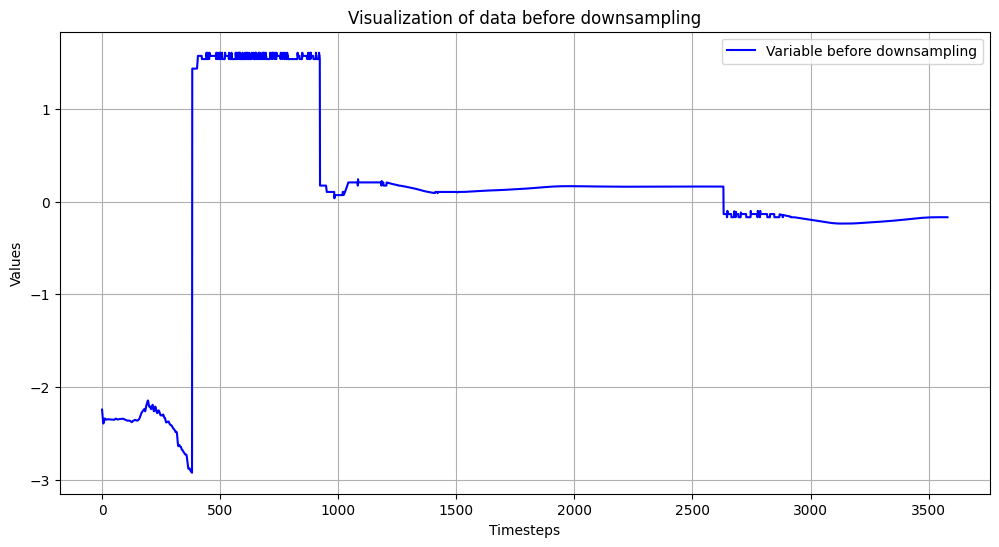

In [15]:
# Create a time axis (0 to 3581)
timesteps = range(train_normal_data.shape[1])

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(timesteps, train_normal_data[0, :, 0], label="Variable before downsampling", color='b')
plt.title("Visualization of data before downsampling")
plt.xlabel("Timesteps")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Function to perform data downsampling
def downsample(data, factor=10):
    """
    Reduces the number of time steps by keeping every `factor`-th step.

    Parameters:
    - data (numpy.array): Data array with the shape (samples, timesteps, features).
    - factor (int): Downsampling factor (default is 10).

    Returns:
    - numpy.array: Data after downsampling.
    """
    return data[:, ::factor, :]  # Keep every `factor`-th step


In [17]:
# Apply downsampling to normalized data and rename variables
train_normal_data_reduced = downsample(train_normal_data)
test_normal_data_reduced = downsample(test_normal_data)
anomaly_data_reduced = downsample(anomaly_data)

# Display sizes of data after preparation and downsampling
print(f"Reduced training data size: {train_normal_data_reduced.shape}")
print(f"Reduced normal test data size: {test_normal_data_reduced.shape}")
print(f"Reduced anomaly data size: {anomaly_data_reduced.shape}")

Reduced training data size: (759, 359, 135)
Reduced normal test data size: (190, 359, 135)
Reduced anomaly data size: (36, 359, 137)


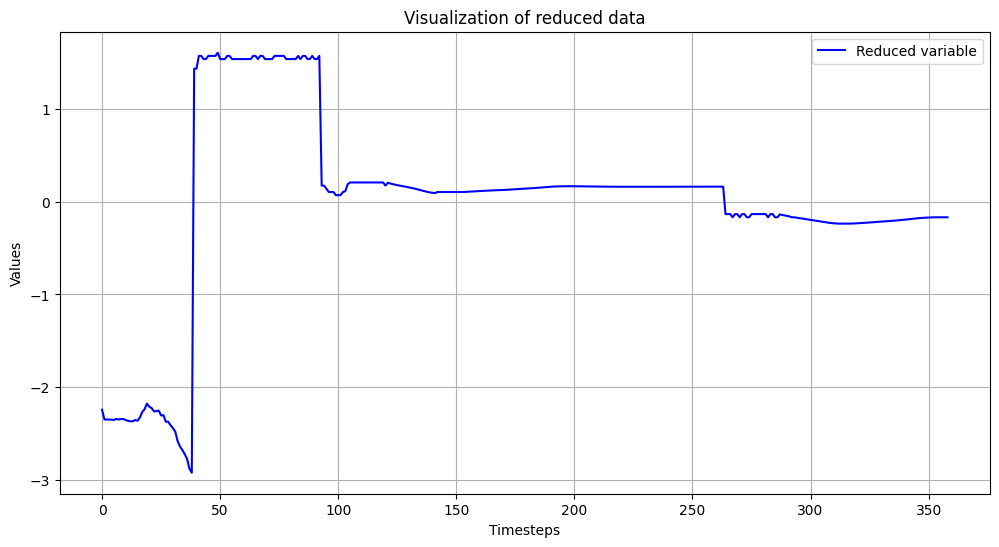

In [18]:
timesteps = range(train_normal_data_reduced.shape[1])

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(timesteps, train_normal_data_reduced[0, :, 0], label="Reduced variable", color='b')
plt.title("Visualization of reduced data")
plt.xlabel("Timesteps")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Split anomalous data into two parts: normal data and ground truth
def split_anomalous_data(data, ground_truth_columns):
    """
    Splits anomalous data into two parts:
    - Normal data (135 columns).
    - Ground truth (2 columns).

    Parameters:
    - data (numpy.array): Anomalous data after preparation (shape: samples, timesteps, features).
    - ground_truth_columns (list): Indices of the ground truth columns.

    Returns:
    - tuple: (normal data, ground truth).
    """
    normal_features = np.delete(data, ground_truth_columns, axis=2)
    ground_truth = data[:, :, ground_truth_columns]
    return normal_features, ground_truth

# Define the indices of the ground truth columns
ground_truth_indices = [135, 136]  # Indices of the ground truth columns (the last two columns)

# Apply the split
anomaly_data_reduced_normal, anomaly_data_ground_truth = split_anomalous_data(anomaly_data_reduced, ground_truth_indices)

print(f"Size of reduced anomalous normal data: {anomaly_data_reduced_normal.shape}")
print(f"Size of ground truths: {anomaly_data_ground_truth.shape}")


Size of reduced anomalous normal data: (36, 359, 135)
Size of ground truths: (36, 359, 2)


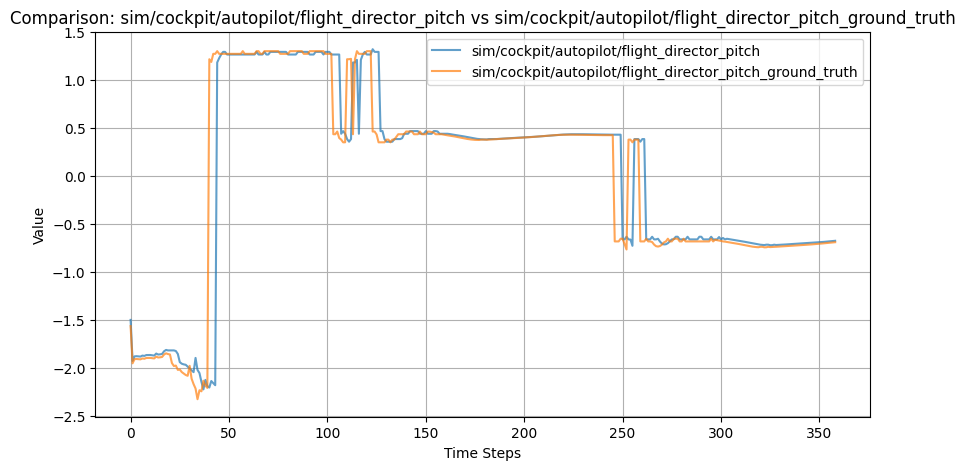

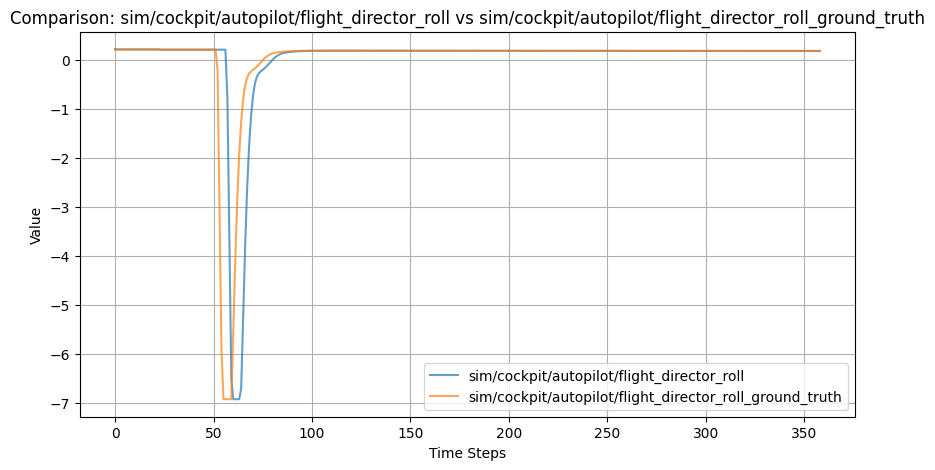

In [20]:
# Function to plot comparisons between variables and their ground truths
def plot_comparison(anomalous_data, ground_truth, feature_names, ground_truth_names, sample_index=0):
    """
    Plots comparisons between anomalous data and their ground truths.

    Parameters:
    - anomalous_data (numpy.array): Anomalous data (samples, timesteps, features).
    - ground_truth (numpy.array): Corresponding ground truths (samples, timesteps, 2).
    - feature_names (list): Names of the variables to plot.
    - ground_truth_names (list): Names of the ground truths.
    - sample_index (int): Index of the sample to plot.
    """
    time_steps = np.arange(anomalous_data.shape[1])

    for i, feature_name in enumerate(feature_names):
        plt.figure(figsize=(10, 5))
        plt.plot(time_steps, anomalous_data[sample_index, :, i], label=f"{feature_name}", alpha=0.7)
        plt.plot(time_steps, ground_truth[sample_index, :, i], label=f"{ground_truth_names[i]}", alpha=0.7)
        plt.xlabel("Time Steps")
        plt.ylabel("Value")
        plt.title(f"Comparison: {feature_name} vs {ground_truth_names[i]}")
        plt.legend()
        plt.grid(True)
        plt.show()


# Plot comparisons for the first sample
plot_comparison(anomaly_data_reduced_normal, anomaly_data_ground_truth, columns_anomalies, columns_ground_truth, sample_index=34)


### Construction du modèle LSTM Autoencoder

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Dropout, concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [22]:
# Data dimensions
timesteps = train_normal_data_reduced.shape[1]  # Number of time steps
input_dim = train_normal_data_reduced.shape[2]  # Number of variables (features)

# Define the LSTM Autoencoder model architecture
inputs = Input(shape=(timesteps, input_dim))

# Encoder: LSTM Layers with Regularization and Dropout
encoded = LSTM(512, activation='tanh', return_sequences=True)(inputs)
# encoded = Dropout(0.2)(encoded)
encoded = LSTM(256, activation='tanh', return_sequences=False)(encoded)

# Bottleneck (latent space)
bottleneck = Dense(128, activation='relu')(encoded)

# Decoder: LSTM Layers
decoded = RepeatVector(timesteps)(bottleneck)
decoded = LSTM(256, activation='tanh', return_sequences=True)(decoded)
# decoded = Dropout(0.2)(decoded)
decoded = LSTM(512, activation='tanh', return_sequences=True)(decoded)

# Output: TimeDistributed(Dense(input_dim)) to reconstruct the data
outputs = TimeDistributed(Dense(input_dim))(decoded)


In [23]:
# Compile the model
autoencoder = tf.keras.Model(inputs, outputs)
autoencoder.compile(optimizer='adam', loss='mse')

In [24]:
# Display the model structure
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 359, 135)]        0         
                                                                 
 lstm (LSTM)                 (None, 359, 512)          1327104   
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 repeat_vector (RepeatVector  (None, 359, 128)         0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 359, 256)          394240    
                                                             

In [25]:
history = autoencoder.fit(
    train_normal_data_reduced, 
    train_normal_data_reduced,  # Normal data for training
    epochs=50, 
    batch_size=32, 
    validation_split=0.2
)

Epoch 1/50
19/19 [==============================] - 12s 277ms/step - loss: 0.9690 - val_loss: 0.9364
Epoch 2/50
19/19 [==============================] - 4s 201ms/step - loss: 0.9463 - val_loss: 1.1470
Epoch 3/50
19/19 [==============================] - 4s 193ms/step - loss: 0.9519 - val_loss: 0.9310
Epoch 4/50
19/19 [==============================] - 4s 195ms/step - loss: 0.9314 - val_loss: 0.9344
Epoch 5/50
19/19 [==============================] - 4s 205ms/step - loss: 0.9321 - val_loss: 0.9214
Epoch 6/50
19/19 [==============================] - 4s 196ms/step - loss: 0.8942 - val_loss: 0.8027
Epoch 7/50
19/19 [==============================] - 4s 196ms/step - loss: 0.7739 - val_loss: 0.6704
Epoch 8/50
19/19 [==============================] - 4s 197ms/step - loss: 0.5388 - val_loss: 0.4385
Epoch 9/50
19/19 [==============================] - 4s 192ms/step - loss: 0.4086 - val_loss: 0.3789
Epoch 10/50
19/19 [==============================] - 4s 205ms/step - loss: 0.3672 - val_loss: 0.348

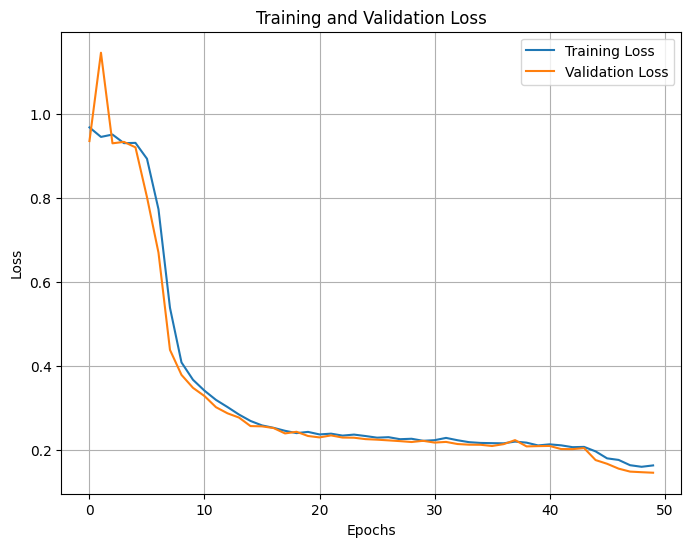

In [26]:
# Plot and save the loss curve
def plot_and_save_loss(history, filename='loss_plot.png'):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)  # Save the plot
    plt.show()

# After training
plot_and_save_loss(history)

In [27]:
# Save the model after training
autoencoder.save('lstm_autoencoder_model.h5')  # Save the model to a .h5 file
print("Model successfully saved")

Model successfully saved


In [28]:
# Load the model after training
autoencoder_loaded = tf.keras.models.load_model('lstm_autoencoder_model.h5')  # Load the saved model

# Check the structure of the loaded model
autoencoder_loaded.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 359, 135)]        0         
                                                                 
 lstm (LSTM)                 (None, 359, 512)          1327104   
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 repeat_vector (RepeatVector  (None, 359, 128)         0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 359, 256)          394240    
                                                             

In [29]:
# Reconstruct anomaly data with the model
reconstructed_anomaly_data = autoencoder_loaded.predict(anomaly_data_reduced_normal)

2/2 [==============================] - 2s 52ms/step


In [30]:
print("Size of original anomaly data (test_anomaly_data_reduced):", anomaly_data_reduced_normal.shape)
print("Size of reconstructed data (reconstructed_anomaly_data):", reconstructed_anomaly_data.shape)
print("Size of ground truth data (ground_truth_data_reduced):", anomaly_data_ground_truth.shape)

Size of original anomaly data (test_anomaly_data_reduced): (36, 359, 135)
Size of reconstructed data (reconstructed_anomaly_data): (36, 359, 135)
Size of ground truth data (ground_truth_data_reduced): (36, 359, 2)


In [31]:
# Function to plot comparisons between original data, ground truths, and reconstructed data
def plot_comparison_with_reconstructed(anomalous_data, ground_truth, reconstructed_data, feature_names, ground_truth_names, sample_index=0):
    """
    Plots comparisons between original data, their ground truths, and reconstructions.

    Parameters:
    - anomalous_data (numpy.array): Original anomalous data (samples, timesteps, features).
    - ground_truth (numpy.array): Corresponding ground truths (samples, timesteps, 2).
    - reconstructed_data (numpy.array): Data reconstructed by the model (samples, timesteps, features).
    - feature_names (list): Names of the variables to plot.
    - ground_truth_names (list): Names of the ground truths.
    - sample_index (int): Index of the sample to plot.
    """
    time_steps = np.arange(anomalous_data.shape[1])

    for i, feature_name in enumerate(feature_names):
        plt.figure(figsize=(10, 5))
        # Original data
        plt.plot(time_steps, anomalous_data[sample_index, :, i], label=f"{feature_name} (Anomalous)", alpha=0.7)
        # Ground truths
        plt.plot(time_steps, ground_truth[sample_index, :, i], label=f"{ground_truth_names[i]} (Ground Truth)", alpha=0.7)
        # Reconstructed data
        plt.plot(time_steps, reconstructed_data[sample_index, :, i], label=f"{feature_name} (Reconstructed)", linestyle='dashed')

        plt.xlabel("Time Steps")
        plt.ylabel("Value")
        plt.title(f"Comparison: {feature_name}, Ground Truth, and Reconstructed")
        plt.legend()
        plt.grid(True)
        plt.show()


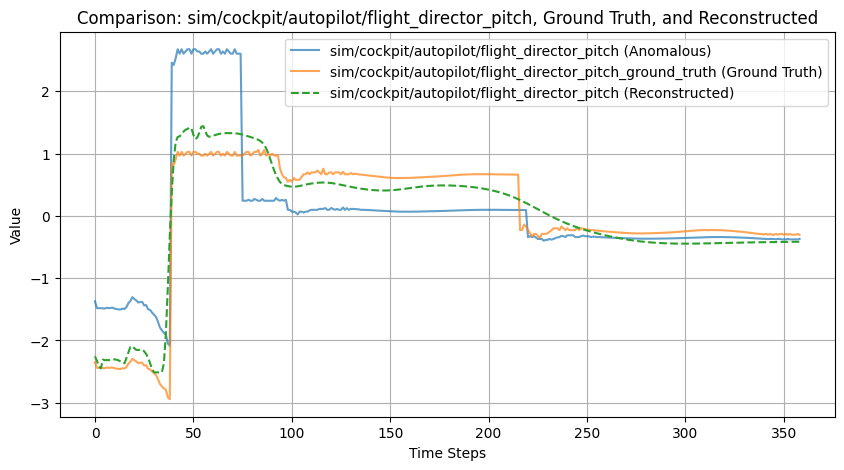

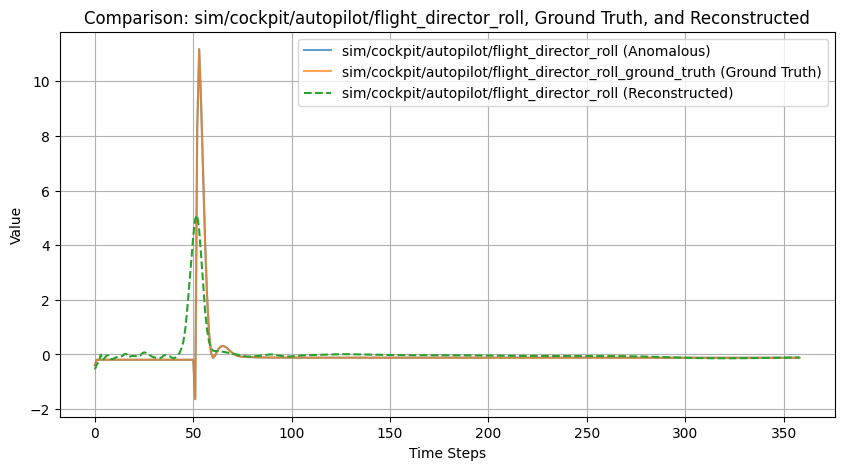

In [37]:
# Plot comparisons
plot_comparison_with_reconstructed(
    anomaly_data_reduced_normal, 
    anomaly_data_ground_truth, 
    reconstructed_anomaly_data, 
    columns_anomalies, 
    columns_ground_truth, 
    sample_index=14  # Change the index to examine other examples
)

### Détection des anomalies

In [33]:
# Calculate the reconstruction error for normal data (train data)
reconstructed_normal = autoencoder_loaded.predict(train_normal_data_reduced)
mse_normal = np.mean(np.square(train_normal_data_reduced - reconstructed_normal), axis=(1, 2))


24/24 [==============================] - 2s 64ms/step


In [34]:
# Determine a threshold to detect anomalies from normal data
threshold = np.percentile(mse_normal, 95)  # Use the 95th percentile of the error as the threshold
print(f"Anomaly detection threshold based on normal data: {threshold}")

Anomaly detection threshold based on normal data: 0.2530597507105338


In [35]:
# Calculate the reconstruction error for normal test data
reconstructed_test_normal = autoencoder_loaded.predict(test_normal_data_reduced)
mse_test_normal = np.mean(np.square(test_normal_data_reduced - reconstructed_test_normal), axis=(1, 2))

# Calculate the reconstruction error for anomalous data
reconstructed_anomalies = autoencoder_loaded.predict(anomaly_data_reduced_normal)
mse_anomalies = np.mean(np.square(anomaly_data_reduced_normal - reconstructed_anomalies), axis=(1, 2))

# Anomaly detection: Compare reconstruction error with the threshold
anomalies = mse_anomalies > threshold  # If the reconstruction error is greater than the threshold, it's an anomaly
print(f"Number of anomalies detected: {np.sum(anomalies)}")


2/2 [==============================] - 0s 50ms/step
Number of anomalies detected: 1


### LSTM Unet Auto-encoder

In [38]:
# Data dimensions
timesteps = train_normal_data_reduced.shape[1]  # Number of time steps
input_dim = train_normal_data_reduced.shape[2]  # Number of variables (features)

# Define the LSTM Autoencoder architecture with Unet
inputs = Input(shape=(timesteps, input_dim))

# Encoder: LSTM Layers
encoded1 = LSTM(512, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.001))(inputs)
encoded2 = LSTM(256, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.001))(encoded1)
encoded3 = LSTM(128, activation='tanh', return_sequences=False, kernel_regularizer=l2(0.001))(encoded2)

# Bottleneck (latent space)
bottleneck = Dense(64, activation='relu')(encoded3)

# Decoder: LSTM Layers
decoded1 = RepeatVector(timesteps)(bottleneck)
decoded2 = LSTM(128, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.001))(decoded1)
decoded2 = concatenate([decoded2, encoded2])  # Skip connection from encoder layer 2
decoded3 = LSTM(256, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.001))(decoded2)
decoded3 = concatenate([decoded3, encoded1])  # Skip connection from encoder layer 1
decoded4 = LSTM(512, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.001))(decoded3)

# Output: TimeDistributed(Dense(input_dim)) to reconstruct the data
outputs = TimeDistributed(Dense(input_dim))(decoded4)

# Compile the model
autoencoder_unet = Model(inputs, outputs)
autoencoder_unet.compile(optimizer='adam', loss='mse')  # Using MSE as the loss function


In [39]:
# Display the model structure
autoencoder_unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 359, 135)]   0           []                               
                                                                                                  
 lstm_4 (LSTM)                  (None, 359, 512)     1327104     ['input_2[0][0]']                
                                                                                                  
 lstm_5 (LSTM)                  (None, 359, 256)     787456      ['lstm_4[0][0]']                 
                                                                                                  
 lstm_6 (LSTM)                  (None, 128)          197120      ['lstm_5[0][0]']                 
                                                                                            

In [40]:
# Early stopping to stop training if validation loss does not improve
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = autoencoder_unet.fit(
    train_normal_data_reduced, 
    train_normal_data_reduced,  # Normal data for training
    epochs=50, 
    batch_size=32, 
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/50
19/19 [==============================] - 13s 376ms/step - loss: 2.5250 - val_loss: 1.5090
Epoch 2/50
19/19 [==============================] - 5s 287ms/step - loss: 1.0185 - val_loss: 0.6211
Epoch 3/50
19/19 [==============================] - 5s 289ms/step - loss: 0.4408 - val_loss: 0.2998
Epoch 4/50
19/19 [==============================] - 6s 306ms/step - loss: 0.2337 - val_loss: 0.1806
Epoch 5/50
19/19 [==============================] - 6s 309ms/step - loss: 0.1510 - val_loss: 0.1268
Epoch 6/50
19/19 [==============================] - 6s 308ms/step - loss: 0.1099 - val_loss: 0.0963
Epoch 7/50
19/19 [==============================] - 5s 290ms/step - loss: 0.0853 - val_loss: 0.0766
Epoch 8/50
19/19 [==============================] - 5s 286ms/step - loss: 0.0715 - val_loss: 0.0666
Epoch 9/50
19/19 [==============================] - 5s 289ms/step - loss: 0.0617 - val_loss: 0.0605
Epoch 10/50
19/19 [==============================] - 6s 291ms/step - loss: 0.0554 - val_loss: 0.062

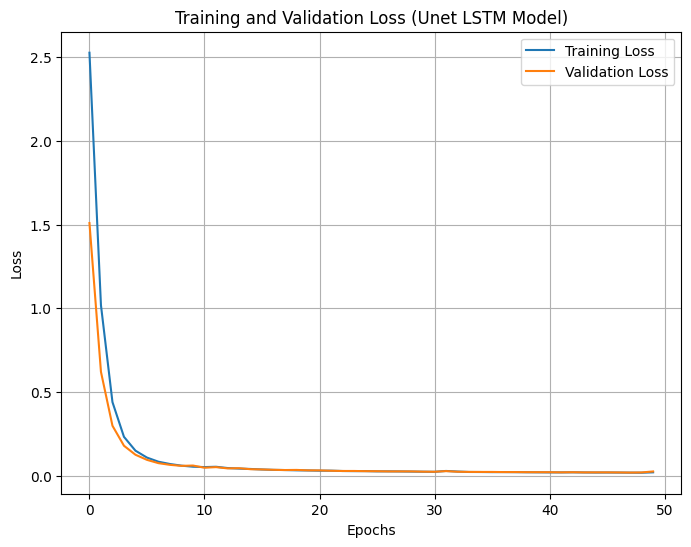

In [41]:
# Plot and save the loss curve
def plot_and_save_loss(history, filename='loss_plot_unet.png'):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss (Unet LSTM Model)')
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)  # Save the plot
    plt.show()

# After training
plot_and_save_loss(history)


In [42]:
# Save the model after training
autoencoder_unet.save('lstm_unet_autoencoder_model.h5')  # Save the model to a .h5 file
print("Unet model successfully saved")

Unet model successfully saved


In [43]:
# Load the model after training
autoencoder_unet_loaded = tf.keras.models.load_model('lstm_unet_autoencoder_model.h5')  # Load the saved model

# Check the structure of the loaded model
autoencoder_unet_loaded.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 359, 135)]   0           []                               
                                                                                                  
 lstm_4 (LSTM)                  (None, 359, 512)     1327104     ['input_2[0][0]']                
                                                                                                  
 lstm_5 (LSTM)                  (None, 359, 256)     787456      ['lstm_4[0][0]']                 
                                                                                                  
 lstm_6 (LSTM)                  (None, 128)          197120      ['lstm_5[0][0]']                 
                                                                                            

In [44]:
# Reconstruction des données anomalies avec le modèle
reconstructed_anomaly_data_unet = autoencoder_unet_loaded.predict(anomaly_data_reduced_normal)

2/2 [==============================] - 2s 89ms/step


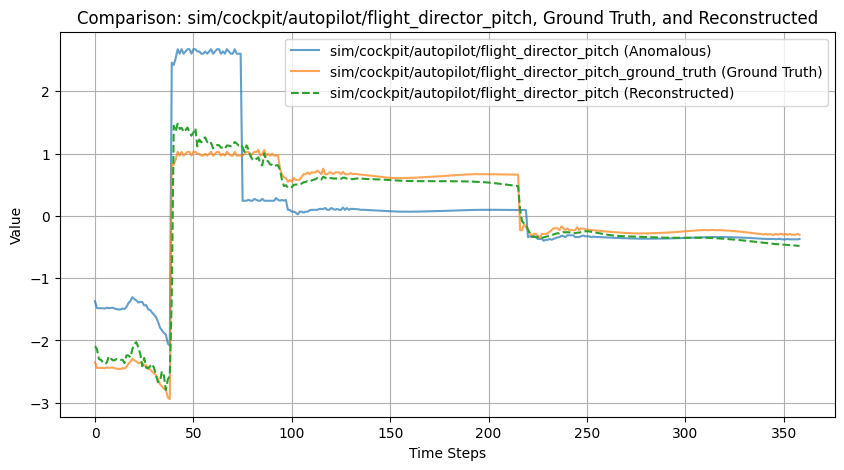

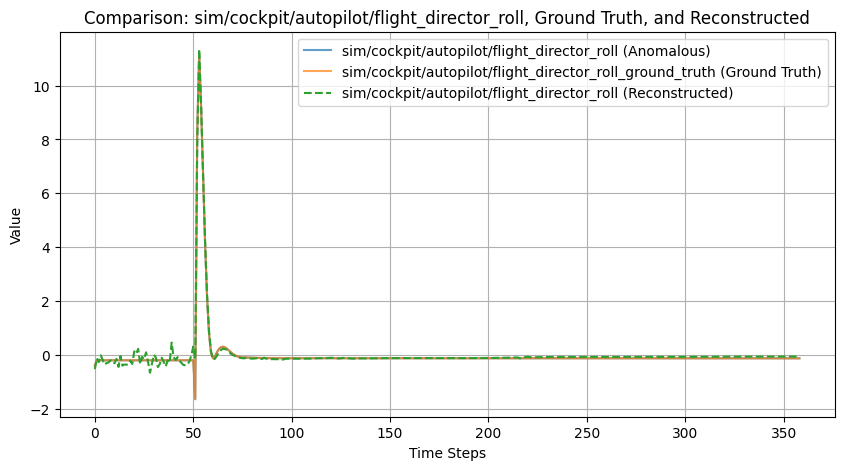

In [65]:
# Plot comparisons
plot_comparison_with_reconstructed(
    anomaly_data_reduced_normal, 
    anomaly_data_ground_truth, 
    reconstructed_anomaly_data_unet, 
    columns_anomalies, 
    columns_ground_truth, 
    sample_index=14  # Change the index to examine other examples
)


In [48]:
# Calculate the reconstruction error for normal data (train data)
reconstructed_normal = autoencoder_unet_loaded.predict(train_normal_data_reduced)
mse_normal = np.mean(np.square(train_normal_data_reduced - reconstructed_normal), axis=(1, 2))


24/24 [==============================] - 3s 105ms/step


In [49]:
# Determine a threshold to detect anomalies from normal data
threshold = np.percentile(mse_normal, 95)  # Use the 95th percentile of the error as the threshold
print(f"Anomaly detection threshold based on normal data: {threshold}")


Anomaly detection threshold based on normal data: 0.03482144085974397


In [50]:
# Calculate the reconstruction error for anomalous data
reconstructed_anomalies = autoencoder_unet_loaded.predict(anomaly_data_reduced_normal)
mse_anomalies = np.mean(np.square(anomaly_data_reduced_normal - reconstructed_anomalies), axis=(1, 2))

2/2 [==============================] - 0s 183ms/step


In [51]:
# Anomaly detection: Compare the reconstruction error with the threshold
anomalies = mse_anomalies > threshold  # If the reconstruction error is greater than the threshold, it's an anomaly
print(f"Number of anomalies detected: {np.sum(anomalies)}")

Number of anomalies detected: 3


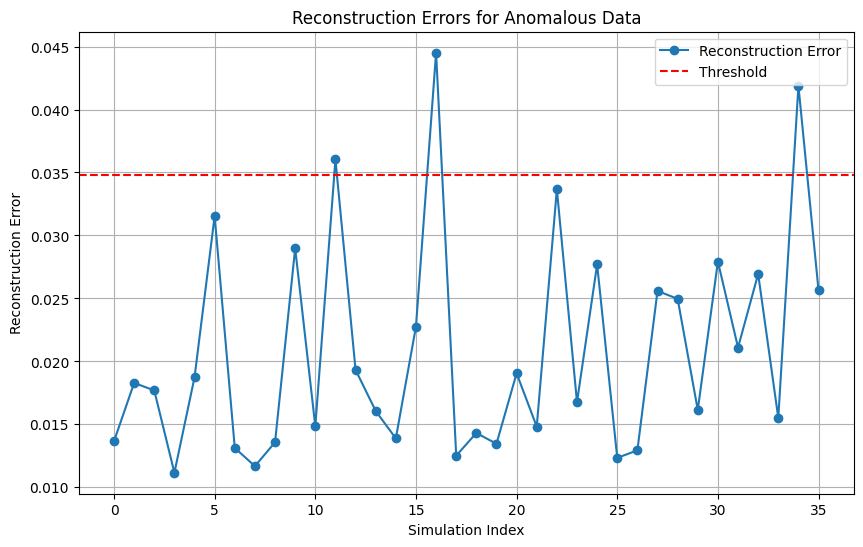

In [52]:
# Plot the reconstruction error for each simulation with the threshold
def plot_reconstruction_errors(errors, threshold, title='Reconstruction Errors with Threshold'):
    plt.figure(figsize=(10, 6))
    plt.plot(errors, marker='o', linestyle='-', label='Reconstruction Error')
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    plt.xlabel('Simulation Index')
    plt.ylabel('Reconstruction Error')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot errors for anomalous data
plot_reconstruction_errors(mse_anomalies, threshold, title='Reconstruction Errors for Anomalous Data')


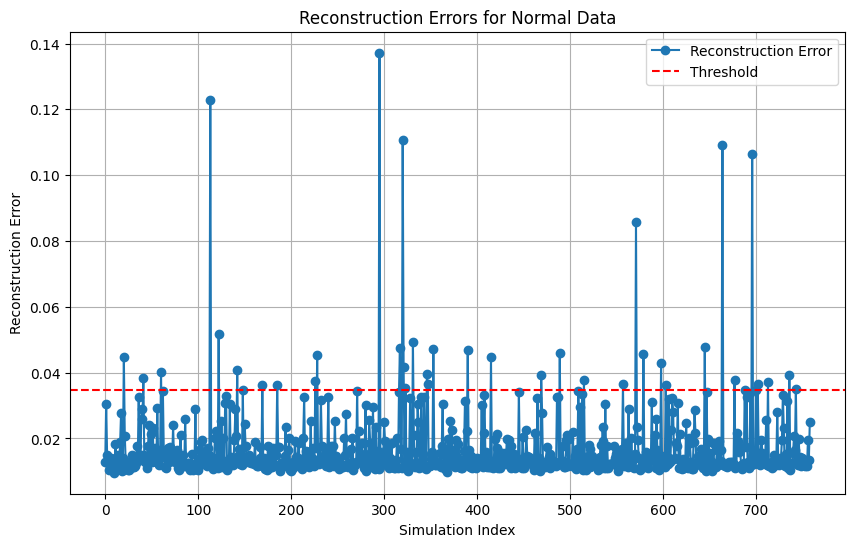

In [53]:
# Plot errors for normal data
plot_reconstruction_errors(mse_normal, threshold, title='Reconstruction Errors for Normal Data')


In [54]:
# Calculate the reconstruction error for normal test data
reconstructed_test_normal = autoencoder_loaded.predict(test_normal_data_reduced)
mse_test_normal = np.mean(np.square(test_normal_data_reduced - reconstructed_test_normal), axis=(1, 2))


6/6 [==============================] - 1s 89ms/step


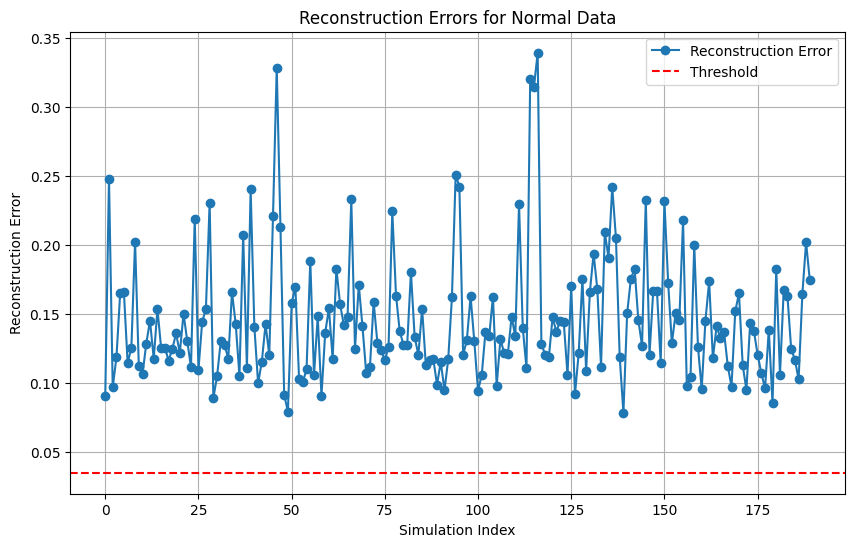

In [55]:
# Plot errors for normal test data
plot_reconstruction_errors(mse_test_normal, threshold, title='Reconstruction Errors for Normal Data')


### Transformer autoencoder

In [56]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Add
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

In [61]:
# Transformer Encoder Layer
def transformer_encoder(inputs, num_heads, ff_dim, dropout_rate=0.1):
    # Multi-head self-attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = Add()([inputs, attention_output])  # Residual connection
    attention_output = LayerNormalization()(attention_output)

    # Feed-forward network
    ff_output = Dense(ff_dim, activation='relu')(attention_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    encoder_output = Add()([attention_output, ff_output])  # Residual connection
    encoder_output = LayerNormalization()(encoder_output)

    return encoder_output

# Transformer Decoder Layer
def transformer_decoder(inputs, encoder_outputs, num_heads, ff_dim, dropout_rate=0.1):
    # Multi-head attention over encoder outputs
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, encoder_outputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = Add()([inputs, attention_output])  # Residual connection
    attention_output = LayerNormalization()(attention_output)

    # Feed-forward network
    ff_output = Dense(ff_dim, activation='relu')(attention_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    decoder_output = Add()([attention_output, ff_output])  # Residual connection
    decoder_output = LayerNormalization()(decoder_output)

    return decoder_output


In [62]:
# Data dimensions
timesteps = train_normal_data_reduced.shape[1]
input_dim = train_normal_data_reduced.shape[2]
num_heads = 4
ff_dim = 128

# Inputs
inputs = Input(shape=(timesteps, input_dim))

# Encoder
encoder_output = transformer_encoder(inputs, num_heads=num_heads, ff_dim=ff_dim)

# Bottleneck
bottleneck = Dense(64, activation='relu')(encoder_output)

# Decoder
decoder_input = Dense(input_dim)(bottleneck)  # Initialize decoder inputs
decoder_output = transformer_decoder(decoder_input, encoder_output, num_heads=num_heads, ff_dim=ff_dim)

# Reconstruction
outputs = Dense(input_dim)(decoder_output)


In [63]:
# Model
transformer_autoencoder = Model(inputs, outputs)
transformer_autoencoder.compile(optimizer='adam', loss='mse')
transformer_autoencoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 359, 135)]   0           []                               
                                                                                                  
 multi_head_attention_2 (MultiH  (None, 359, 135)    293355      ['input_4[0][0]',                
 eadAttention)                                                    'input_4[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 359, 135)     0           ['multi_head_attention_2[0][0]'] 
                                                                                                  
 add_4 (Add)                    (None, 359, 135)     0           ['input_4[0][0]',          

In [64]:
# Train
history = transformer_autoencoder.fit(
    train_normal_data_reduced,
    train_normal_data_reduced,
    epochs=50,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/50
19/19 [==============================] - 4s 124ms/step - loss: 0.8970 - val_loss: 0.4535
Epoch 2/50
19/19 [==============================] - 2s 100ms/step - loss: 0.4047 - val_loss: 0.2913
Epoch 3/50
19/19 [==============================] - 2s 100ms/step - loss: 0.2858 - val_loss: 0.2197
Epoch 4/50
19/19 [==============================] - 2s 99ms/step - loss: 0.2216 - val_loss: 0.1742
Epoch 5/50
19/19 [==============================] - 2s 99ms/step - loss: 0.1775 - val_loss: 0.1404
Epoch 6/50
19/19 [==============================] - 2s 100ms/step - loss: 0.1445 - val_loss: 0.1140
Epoch 7/50
19/19 [==============================] - 2s 100ms/step - loss: 0.1197 - val_loss: 0.0942
Epoch 8/50
19/19 [==============================] - 2s 100ms/step - loss: 0.1001 - val_loss: 0.0776
Epoch 9/50
19/19 [==============================] - 2s 99ms/step - loss: 0.0842 - val_loss: 0.0649
Epoch 10/50
19/19 [==============================] - 2s 100ms/step - loss: 0.0716 - val_loss: 0.0546
Ep

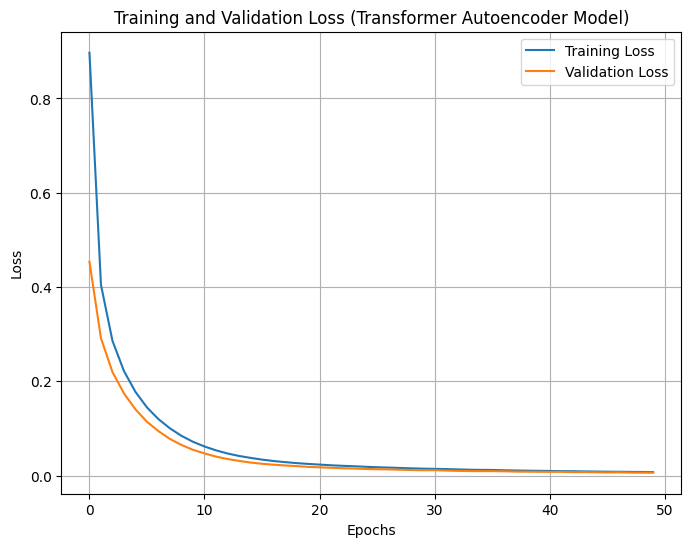

In [68]:
# Plot loss
def plot_and_save_loss(history, filename='loss_plot_transformer.png'):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss (Transformer Autoencoder Model)')
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)  # Enregistrer le graphe
    plt.show()

plot_and_save_loss(history)

In [69]:
# Save the model after training
transformer_autoencoder.save('transformer_autoencoder_model.h5')  # Save the model to a .h5 file
print("Transformer Autoencoder model successfully saved")

Transformer Autoencoder model successfully saved


In [70]:
# Load the model after training
transformer_autoencoder_loaded = tf.keras.models.load_model('transformer_autoencoder_model.h5')  # Load the saved model

# Check the structure of the loaded model
transformer_autoencoder_loaded.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 359, 135)]   0           []                               
                                                                                                  
 multi_head_attention_2 (MultiH  (None, 359, 135)    293355      ['input_4[0][0]',                
 eadAttention)                                                    'input_4[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 359, 135)     0           ['multi_head_attention_2[0][0]'] 
                                                                                                  
 add_4 (Add)                    (None, 359, 135)     0           ['input_4[0][0]',          

In [74]:
# Reconstruct anomalous data with the Transformer model
reconstructed_anomaly_transformer = transformer_autoencoder_loaded.predict(anomaly_data_reduced_normal)

2/2 [==============================] - 0s 11ms/step


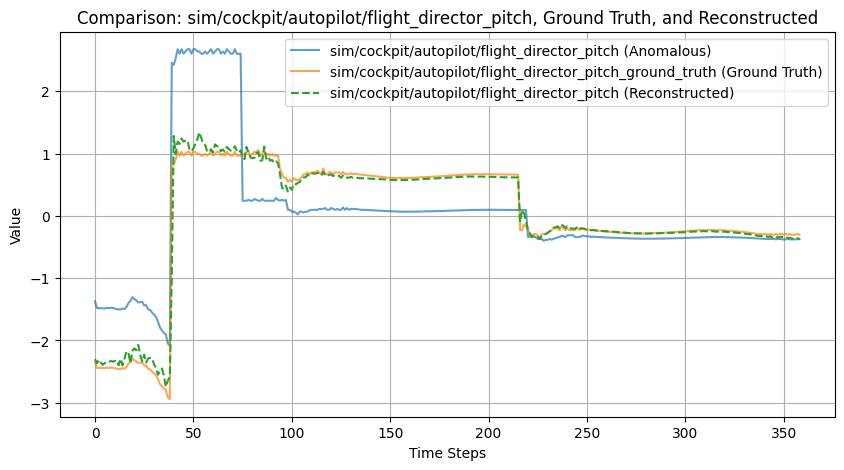

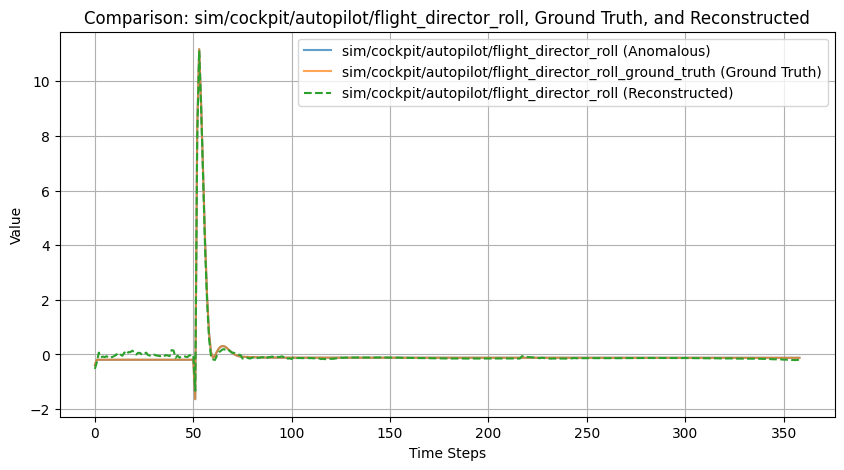

In [75]:
# Plot comparisons for the first sample (Transformer)
plot_comparison_with_reconstructed(
    anomaly_data_reduced_normal, 
    anomaly_data_ground_truth, 
    reconstructed_anomaly_transformer,  # Data reconstructed by the Transformer model
    columns_anomalies, 
    columns_ground_truth, 
    sample_index=14  # Change the index to examine other examples
)

In [76]:
# Calculate the reconstruction error for normal data (train data)
reconstructed_normal = transformer_autoencoder.predict(train_normal_data_reduced)
mse_normal = np.mean(np.square(train_normal_data_reduced - reconstructed_normal), axis=(1, 2))

# Determine a threshold to detect anomalies from normal data
threshold = np.percentile(mse_normal, 95)  # Use the 95th percentile of the error as the threshold
print(f"Anomaly detection threshold based on normal data: {threshold}")


24/24 [==============================] - 1s 36ms/step
Anomaly detection threshold based on normal data: 0.011466487317504197


In [77]:
# Calculate the reconstruction error for normal test data
reconstructed_test_normal = transformer_autoencoder.predict(test_normal_data_reduced)
mse_test_normal = np.mean(np.square(test_normal_data_reduced - reconstructed_test_normal), axis=(1, 2))

# Calculate the reconstruction error for anomalous data
reconstructed_anomalies = transformer_autoencoder.predict(anomaly_data_reduced_normal)
mse_anomalies = np.mean(np.square(anomaly_data_reduced_normal - reconstructed_anomalies), axis=(1, 2))

# Anomaly detection: Compare the reconstruction error with the threshold
anomalies = mse_anomalies > threshold  # If the reconstruction error is greater than the threshold, it's an anomaly
print(f"Number of anomalies detected: {np.sum(anomalies)}")


2/2 [==============================] - 0s 10ms/step
Number of anomalies detected: 4


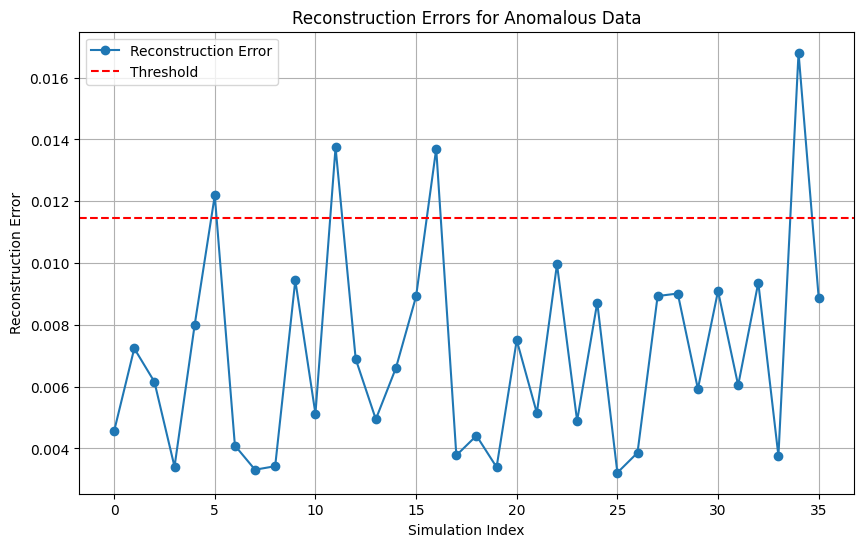

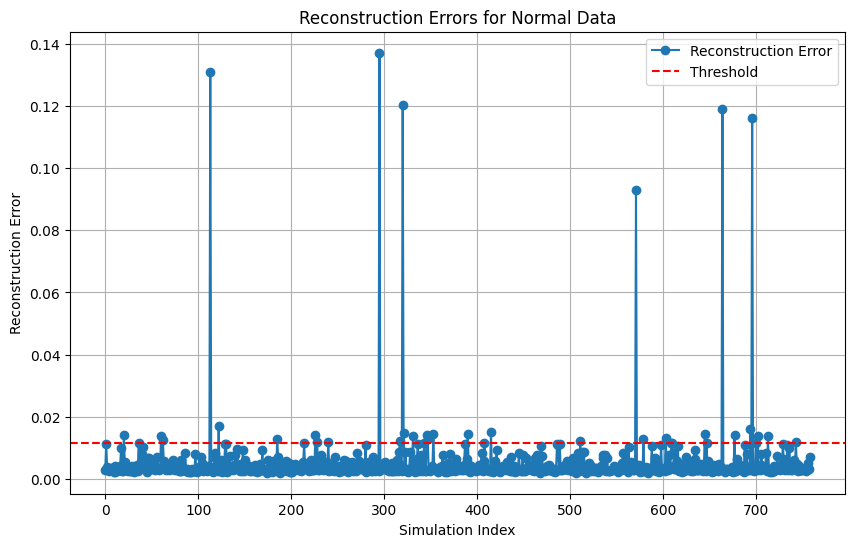

In [78]:
# Plot errors for anomalous data
plot_reconstruction_errors(mse_anomalies, threshold, title='Reconstruction Errors for Anomalous Data')

# Plot errors for normal data
plot_reconstruction_errors(mse_normal, threshold, title='Reconstruction Errors for Normal Data')
